# This demo shows how to use the Bayesian Representational Similarity Analysis method in brainiak with a simulated dataset.

#### Load some package which we will use in this demo.
If you see error related to loading any package, you can install that package. For example, if you use Anaconda, you can use "conda install matplotlib" to install matplotlib.

In [1]:
%matplotlib inline
import scipy.stats
import scipy.spatial.distance as spdist
import numpy as np
from brainiak.reprsimil.brsa import BRSA
from brainiak.reprsimil.brsa import GBRSA
import brainiak.utils.utils as utils
import matplotlib.pyplot as plt
import logging
np.random.seed(10)

#### You might want to keep a log of the output.

In [2]:
logging.basicConfig(
    level=logging.DEBUG,
    filename='brsa_example.log',
    format='%(relativeCreated)6d %(threadName)s %(message)s')

# We want to simulate some data in which each voxel responds to different task conditions differently, but following a common covariance structure

## Load an example design matrix.
The user should prepare their design matrix with their favorate software, such as using 3ddeconvolve of AFNI, or using SPM or FSL.
The design matrix reflects your belief of how fMRI signal should respond to a task (if a voxel does respond).
The common assumption is that a neural event that you are interested in will elicit a slow hemodynamic response in some voxels. The response peaks around 4-6 seconds after the event onset and dies down more than 12 seconds after the event. Therefore, typically you convolve a time series A, composed of delta (stem) functions reflecting the time of each neural event belonging to the same category (e.g. all trials in which a participant sees a face), with a hemodynamic response function B, to form the hypothetic response of any voxel to such type of neural event.
For each type of event, such a convoluted time course can be generated. These time courses, put together, are called design matrix, reflecting what we believe a temporal signal would look like, if it exists in any voxel.
Our goal is to figure out how the (spatial) response pattern of a population of voxels (in an Region of Interest, ROI) are similar or disimilar to different types of tasks (e.g., watching face vs. house, watching different categories of animals, different conditions of a cognitive task). So we need the design matrix in order to estimate the similarity matrix we are interested.

We can use the utility called ReadDesign to read a design matrix generated from AFNI. For design matrix saved as Matlab data file by SPM or or other toolbox, you can use scipy.io.loadmat('YOURFILENAME') and extract the design matrix from the dictionary returned. Basically, the Bayesian RSA in this toolkit just needs a numpy array which is in size of {time points} * {condition}

In typical fMRI analysis, some nuisance regressors such as head motion, baseline time series and slow drift are also entered into regression. In using our method, you should not include such regressors into the design matrix, because the spatial spread of such nuisance regressors might be quite different from the spatial spread of task related signal. Including such nuisance regressors in design matrix might influence the pseudo-SNR map, which in turn influence the estimation of the shared covariance matrix. 

### We concatenate the design matrix by 2 times, mimicking 2 runs of identical timing

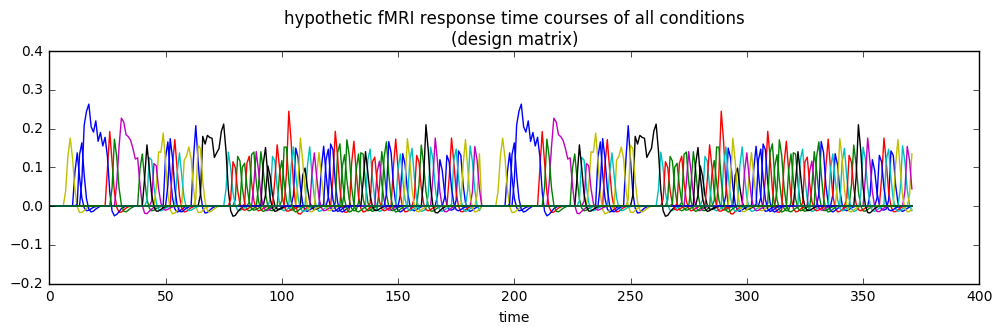

In [3]:
design = utils.ReadDesign(fname="example_design.1D")

n_run = 2
design.n_TR = design.n_TR * n_run
design.design_task = np.tile(design.design_task[:,:-1],
                             [n_run, 1])
# The last "condition" in design matrix
# codes for trials subjects made and error.
# We ignore it here.


fig = plt.figure(num=None, figsize=(12, 3),
                 dpi=150, facecolor='w', edgecolor='k')
plt.plot(design.design_task)
plt.ylim([-0.2, 0.4])
plt.title('hypothetic fMRI response time courses '
          'of all conditions\n'
         '(design matrix)')
plt.xlabel('time')
plt.show()

n_C = np.size(design.design_task, axis=1)
# The total number of conditions.
ROI_edge = 30
# We simulate "ROI" of a square shape
n_V = ROI_edge**2
# The total number of simulated voxels
n_T = design.n_TR
# The total number of time points,
# after concatenating all fMRI runs


## simulate data: noise + signal
### First, we start with noise, which is Gaussian Process in space and AR(1) in time

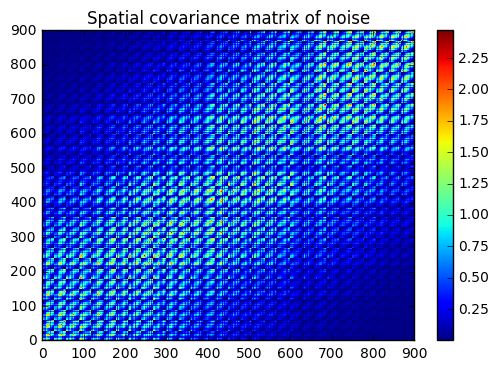

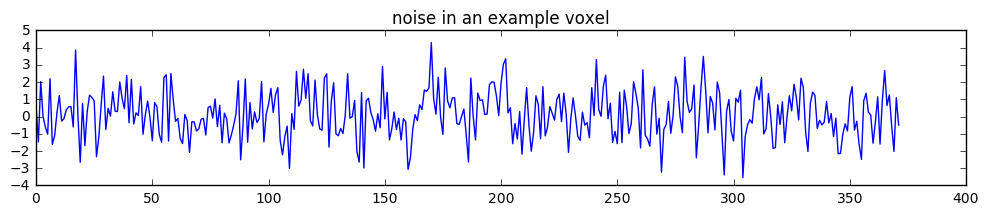

In [4]:
noise_bot = 0.5
noise_top = 1.5
noise_level = np.random.rand(n_V) * \
    (noise_top - noise_bot) + noise_bot
# The standard deviation of the noise is in the range of [noise_bot, noise_top]
# In fact, we simulate autocorrelated noise with AR(1) model. So the noise_level reflects
# the independent additive noise at each time point (the "fresh" noise)

# AR(1) coefficient
rho1_top = 0.8
rho1_bot = -0.2
rho1 = np.random.rand(n_V) \
    * (rho1_top - rho1_bot) + rho1_bot

noise_smooth_width = 10.0
coords = np.mgrid[0:ROI_edge, 0:ROI_edge, 0:1]
coords_flat = np.reshape(coords,[3, n_V]).T
dist2 = spdist.squareform(spdist.pdist(coords_flat, 'sqeuclidean'))

# generating noise
K_noise = noise_level[:, np.newaxis] \
    * (np.exp(-dist2 / noise_smooth_width**2 / 2.0) \
       + np.eye(n_V) * 0.1) * noise_level
# We make spatially correlated noise by generating
# noise at each time point from a Gaussian Process
# defined over the coordinates.
plt.pcolor(K_noise)
plt.colorbar()
plt.xlim([0, ROI_edge * ROI_edge])
plt.ylim([0, ROI_edge * ROI_edge])
plt.title('Spatial covariance matrix of noise')
plt.show()
L_noise = np.linalg.cholesky(K_noise)
noise = np.zeros([n_T, n_V])
noise[0, :] = np.dot(L_noise, np.random.randn(n_V))\
    / np.sqrt(1 - rho1**2)
for i_t in range(1, n_T):
    noise[i_t, :] = noise[i_t - 1, :] * rho1 \
        + np.dot(L_noise,np.random.randn(n_V))
# For each voxel, the noise follows AR(1) process:
# fresh noise plus a dampened version of noise at
# the previous time point.
fig = plt.figure(num=None, figsize=(12, 2), dpi=150,
                 facecolor='w', edgecolor='k')
plt.plot(noise[:, 0])
plt.title('noise in an example voxel')
plt.show()

### Then, we simulate signals, assuming the magnitude of response to each condition follows a common covariance matrix. 
#### Our model allows to impose a Gaussian Process prior on the log(SNR) of each voxels. 
What this means is that SNR turn to be smooth and local, but betas (response amplitudes of each voxel to each condition) are not necessarily correlated in space. Intuitively, this is based on the assumption that voxels coding for related aspects of a task turn to be clustered (instead of isolated)

Our Gaussian Process are defined on both the coordinate of a voxel and its mean intensity.
This means that voxels close together AND have similar intensity should have similar SNR level. Therefore, voxels of white matter but adjacent to gray matters do not necessarily have high SNR level.

If you have an ROI saved as a binary Nifti file, say, with name 'ROI.nii'
Then you can use nibabel package to load the ROI and the following example code to retrive the coordinates of voxels.


##### Note: the following code won't work if you just installed Brainiak and try this demo because ROI.nii does not exist. It just serves as an example for you to retrieve coordinates of voxels in an ROI. You can use the ROI_coords for the argument coords in BRSA.fit()

In [5]:
# import nibabel
# ROI = nibabel.load('ROI.nii')
# I,J,K = ROI.shape 
# all_coords = np.zeros((I, J, K, 3)) 
# all_coords[...,0] = np.arange(I)[:, np.newaxis, np.newaxis] 
# all_coords[...,1] = np.arange(J)[np.newaxis, :, np.newaxis] 
# all_coords[...,2] = np.arange(K)[np.newaxis, np.newaxis, :] 
# ROI_coords = nibabel.affines.apply_affine(
#     ROI.affine, all_coords[ROI.get_data().astype(bool)])


#### Let's keep in mind of the pattern of the ideal covariance / correlation below and see how well BRSA can recover their patterns.

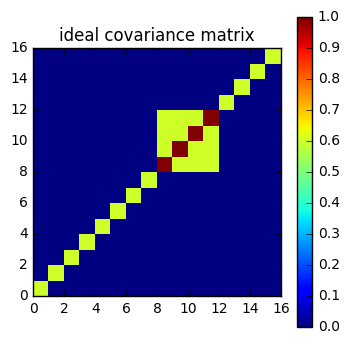

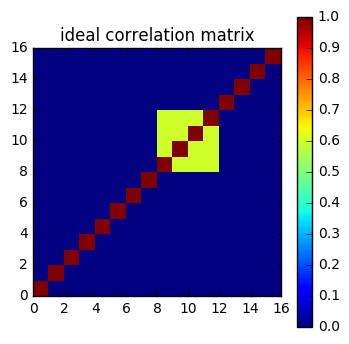

In [6]:
# ideal covariance matrix
ideal_cov = np.zeros([n_C, n_C])
ideal_cov = np.eye(n_C) * 0.6
ideal_cov[8:12, 8:12] = 0.6
for cond in range(8, 12):
    ideal_cov[cond,cond] = 1

fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(ideal_cov)
plt.colorbar()
plt.xlim([0, 16])
plt.ylim([0, 16])
ax = plt.gca()
ax.set_aspect(1)
plt.title('ideal covariance matrix')
plt.show()

std_diag = np.diag(ideal_cov)**0.5
ideal_corr = ideal_cov / std_diag / std_diag[:, None]
fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(ideal_corr)
plt.colorbar()
plt.xlim([0, 16])
plt.ylim([0, 16])
ax = plt.gca()
ax.set_aspect(1)
plt.title('ideal correlation matrix')
plt.show()

#### In the following, pseudo-SNR is generated from a Gaussian Process defined on a "square" ROI, just for simplicity of code

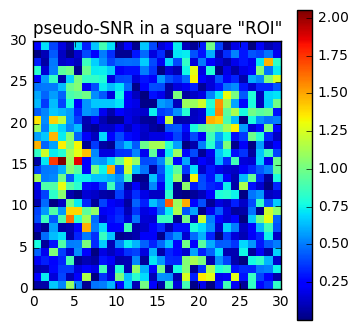

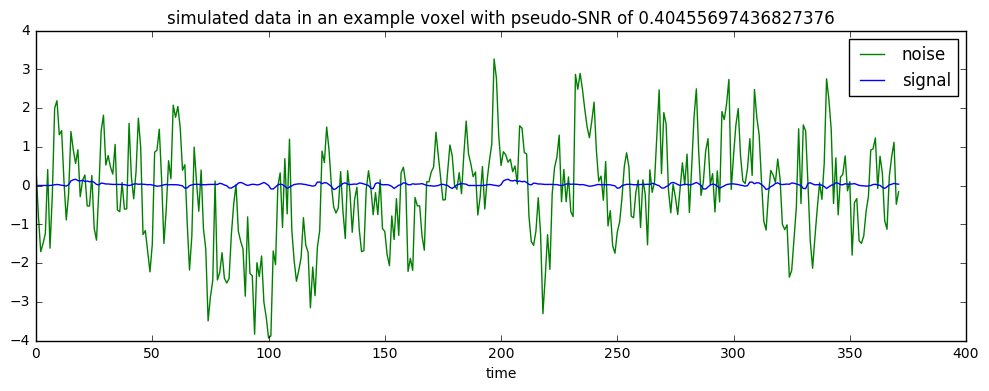

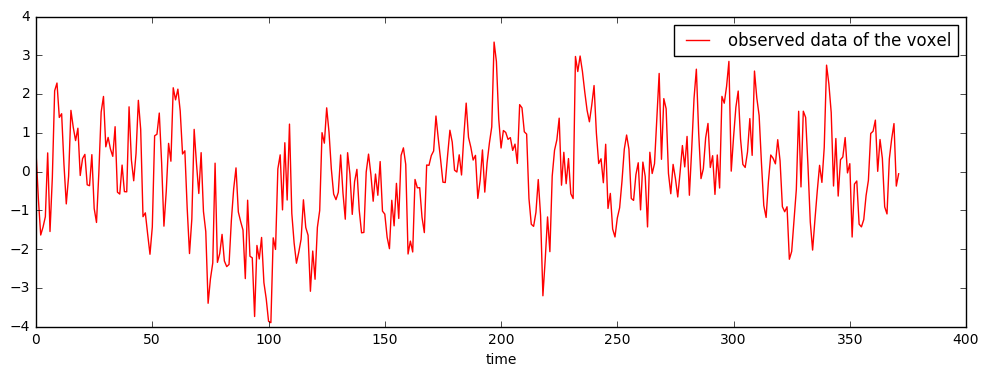

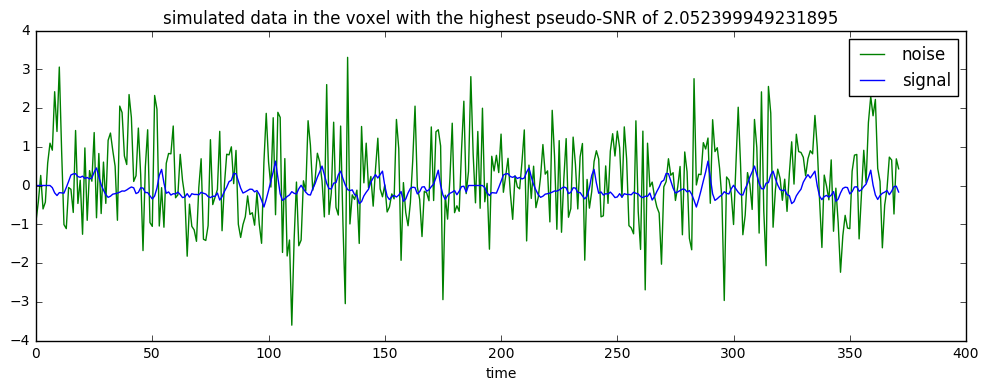

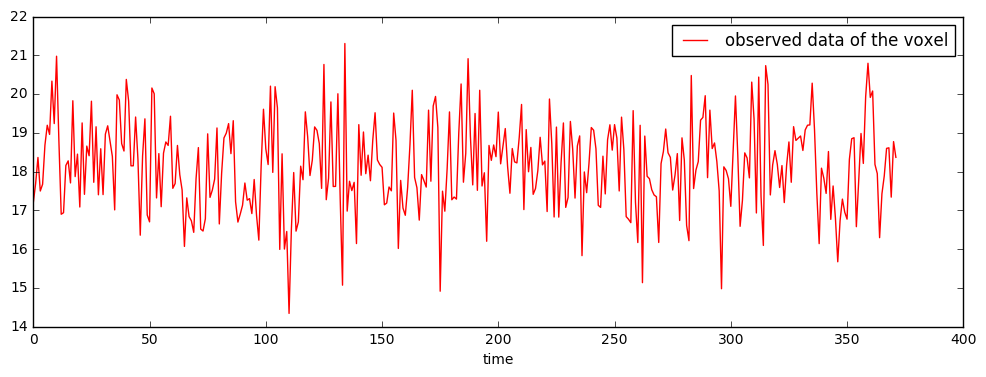

In [7]:
L_full = np.linalg.cholesky(ideal_cov)        

# generating signal
snr_level = 1.0
# Notice that accurately speaking this is not SNR.
# The magnitude of signal depends not only on beta but also on x.
# (noise_level*snr_level)**2 is the factor multiplied
# with ideal_cov to form the covariance matrix from which
# the response amplitudes (beta) of a voxel are drawn from.

tau = 0.6
# magnitude of Gaussian Process from which the log(SNR) is drawn
smooth_width = 3.0
# spatial length scale of the Gaussian Process, unit: voxel
inten_kernel = 4.0
# intensity length scale of the Gaussian Process
# Slightly counter-intuitively, if this parameter is very large,
# say, much larger than the range of intensities of the voxels,
# then the smoothness has much small dependency on the intensity.


inten = np.random.rand(n_V) * 20.0
# For simplicity, we just assume that the intensity
# of all voxels are uniform distributed between 0 and 20
# parameters of Gaussian process to generate pseuso SNR
# For curious user, you can also try the following commond
# to see what an example snr map might look like if the intensity
# grows linearly in one spatial direction

# inten = coords_flat[:,0] * 2


inten_tile = np.tile(inten, [n_V, 1])
inten_diff2 = (inten_tile - inten_tile.T)**2

K = np.exp(-dist2 / smooth_width**2 / 2.0 
           - inten_diff2 / inten_kernel**2 / 2.0) * tau**2 \
    + np.eye(n_V) * tau**2 * 0.001
# A tiny amount is added to the diagonal of
# the GP covariance matrix to make sure it can be inverted
L = np.linalg.cholesky(K)
# snr = np.exp(np.dot(L, np.random.randn(n_V))) * snr_level
snr = np.abs(np.dot(L, np.random.randn(n_V))) * snr_level
sqrt_v = noise_level * snr
betas_simulated = np.dot(L_full, np.random.randn(n_C, n_V)) * sqrt_v
signal = np.dot(design.design_task, betas_simulated)


Y = signal + noise + inten
# The data to be fed to the program.


fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(np.reshape(snr, [ROI_edge, ROI_edge]))
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('pseudo-SNR in a square "ROI"')
plt.show()

idx = np.argmin(np.abs(snr - np.median(snr)))
# choose a voxel of medium level SNR.
fig = plt.figure(num=None, figsize=(12, 4), dpi=150,
                 facecolor='w', edgecolor='k')
noise_plot, = plt.plot(noise[:,idx],'g')
signal_plot, = plt.plot(signal[:,idx],'b')
plt.legend([noise_plot, signal_plot], ['noise', 'signal'])
plt.title('simulated data in an example voxel'
          ' with pseudo-SNR of {}'.format(snr[idx]))
plt.xlabel('time')
plt.show()

fig = plt.figure(num=None, figsize=(12, 4), dpi=150,
                 facecolor='w', edgecolor='k')
data_plot, = plt.plot(Y[:,idx],'r')
plt.legend([data_plot], ['observed data of the voxel'])
plt.xlabel('time')
plt.show()

idx = np.argmin(np.abs(snr - np.max(snr)))
# display the voxel of the highest level SNR.
fig = plt.figure(num=None, figsize=(12, 4), dpi=150,
                 facecolor='w', edgecolor='k')
noise_plot, = plt.plot(noise[:,idx],'g')
signal_plot, = plt.plot(signal[:,idx],'b')
plt.legend([noise_plot, signal_plot], ['noise', 'signal'])
plt.title('simulated data in the voxel with the highest'
          ' pseudo-SNR of {}'.format(snr[idx]))
plt.xlabel('time')
plt.show()

fig = plt.figure(num=None, figsize=(12, 4), dpi=150,
                 facecolor='w', edgecolor='k')
data_plot, = plt.plot(Y[:,idx],'r')
plt.legend([data_plot], ['observed data of the voxel'])
plt.xlabel('time')
plt.show()


#### The reason that the pseudo-SNRs in the example voxels are not too small, while the signal looks much smaller is because we happen to have low amplitudes in our design matrix. The true SNR depends on both the amplitudes in design matrix and the pseudo-SNR. Therefore, be aware that pseudo-SNR does not directly reflects how much signal the data have, but rather a map indicating the relative strength of signal in differerent voxels.
#### When you have multiple runs, the noise won't be correlated between runs. Therefore, you should tell BRSA when is the onset of each scan. 
#### Note that the data (variable Y above) you feed to BRSA is the concatenation of data from all runs along the time dimension, as a 2-D matrix of time x space

In [8]:
scan_onsets = np.int32(np.linspace(0, design.n_TR,num=n_run + 1)[: -1])
print('scan onsets: {}'.format(scan_onsets))

scan onsets: [  0 186]


# Fit Bayesian RSA to our simulated data
### The data should be z-scored along time dimension. Otherwise voxels of high variance in noise can dominate the estimation of spatially shared noise component.

The nuisance regressors in typical fMRI analysis (such as head motion signal) are replaced by principal components estimated from residuals after subtracting task-related response. n_nureg tells the model how many principal components to keep from the residual as nuisance regressors, in order to account for spatial correlation in noise. 
If you prefer not using this approach based on principal components of residuals, you can set auto_nuisance=False, and optionally provide your own nuisance regressors as nuisance argument to BRSA.fit()

In [9]:
Y_z = scipy.stats.zscore(Y,axis=0)
Y_std = np.std(Y,axis=0)
# Z-scoreing the data

brsa = BRSA(GP_space=True, GP_inten=True, nureg_method='PCA',
            n_nureg=20, auto_nuisance=True, anneal_speed=2, prior_ts_cov='Full')
# brsa = BRSA(nureg_method='PCA',
#             n_nureg=20, auto_nuisance=True, anneal_speed=10, prior_ts_cov='Full')
# Initiate an instance, telling it
# that we want to impose Gaussian Process prior
# over both space and intensity.
z_score = True

if z_score:
    brsa.fit(X=Y_z, design=design.design_task,
             coords=coords_flat, inten=inten, scan_onsets=scan_onsets)
else:
    brsa.fit(X=Y, design=design.design_task,
             coords=coords_flat, inten=inten, scan_onsets=scan_onsets)

# The data to fit should be given to the argument X.
# Design matrix goes to design. And so on.


### We can have a look at the estimated similarity in matrix brsa.C_. 
#### We can also compare the ideal covariance above with the one recovered, brsa.U_

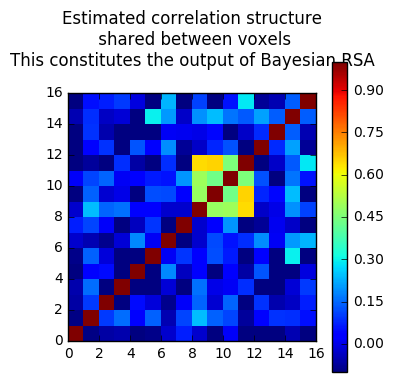

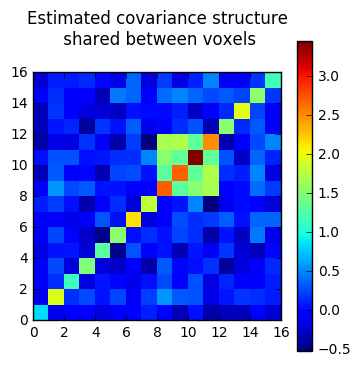

In [10]:
fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(brsa.C_, vmin=-0.1, vmax=1)
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('Estimated correlation structure\n shared between voxels\n'
         'This constitutes the output of Bayesian RSA\n')
plt.show()

fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(brsa.U_)
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('Estimated covariance structure\n shared between voxels\n')
plt.show()

### In contrast, we can have a look of the similarity matrix based on Pearson correlation between point estimates of betas of different conditions.
#### This is what vanila RSA might give

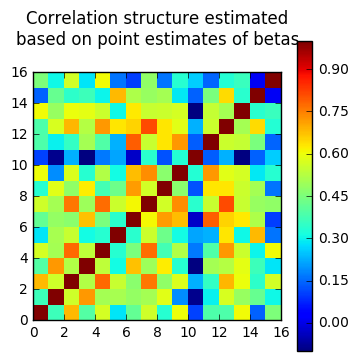

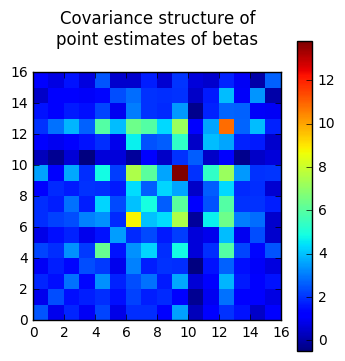

In [11]:
regressor = np.insert(design.design_task,
                      0, 1, axis=1)
betas_point = np.linalg.lstsq(regressor, Y_z)[0]
point_corr = np.corrcoef(betas_point[1:, :])
point_cov = np.cov(betas_point[1:, :])
fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(point_corr, vmin=-0.1, vmax=1)
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('Correlation structure estimated\n'
         'based on point estimates of betas\n')
plt.show()

fig = plt.figure(num=None, figsize=(4, 4), dpi=100)
plt.pcolor(point_cov)
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
plt.title('Covariance structure of\n'
         'point estimates of betas\n')
plt.show()

### We can make a comparison between the estimated SNR map and the true SNR map (normalized)

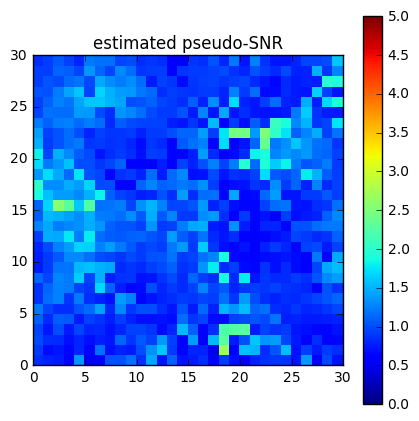

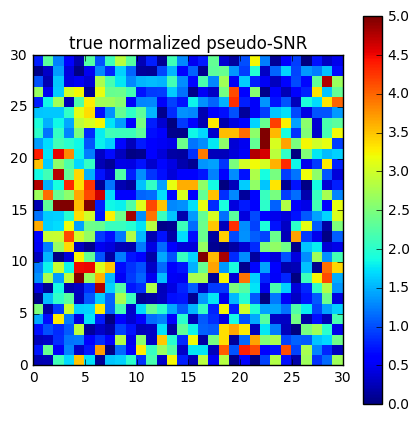

In [12]:
fig = plt.figure(num=None, figsize=(5, 5), dpi=100)
plt.pcolor(np.reshape(brsa.nSNR_, [ROI_edge, ROI_edge]), vmin=0, vmax=5)
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
ax.set_title('estimated pseudo-SNR')
plt.show()

fig = plt.figure(num=None, figsize=(5, 5), dpi=100)
plt.pcolor(np.reshape(snr / np.exp(np.mean(np.log(snr))),
                      [ROI_edge, ROI_edge]), vmin=0, vmax=5)
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
ax.set_title('true normalized pseudo-SNR')
plt.show()

In [13]:
RMS_BRSA = np.mean((brsa.C_ - ideal_corr)**2)**0.5
RMS_RSA = np.mean((point_corr - ideal_corr)**2)**0.5
print('RMS error of Bayesian RSA: {}'.format(RMS_BRSA))
print('RMS error of standard RSA: {}'.format(RMS_RSA))
print('Recovered spatial smoothness length scale: '
      '{}, vs. true value: {}'.format(brsa.lGPspace_, smooth_width))
print('Recovered intensity smoothness length scale: '
      '{}, vs. true value: {}'.format(brsa.lGPinten_, inten_kernel))
print('Recovered standard deviation of GP prior: '
      '{}, vs. true value: {}'.format(brsa.bGP_, tau))

RMS error of Bayesian RSA: 0.12967171665599492
RMS error of standard RSA: 0.4649960230622386
Recovered spatial smoothness length scale: 5.35610288293815, vs. true value: 3.0
Recovered intensity smoothness length scale: 8.347096173343886, vs. true value: 4.0
Recovered standard deviation of GP prior: 0.6196717007019895, vs. true value: 0.6


#### Empirically, the smoothness turns to be over-estimated when signal is weak.

### We can also look at how other parameters are recovered.

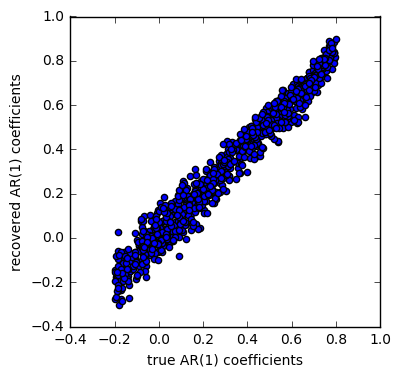

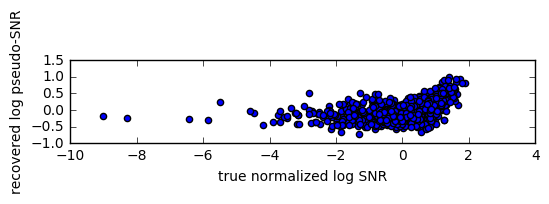

In [14]:

plt.scatter(rho1, brsa.rho_)
plt.xlabel('true AR(1) coefficients')
plt.ylabel('recovered AR(1) coefficients')
ax = plt.gca()
ax.set_aspect(1)
plt.show()

plt.scatter(np.log(snr) - np.mean(np.log(snr)),
            np.log(brsa.nSNR_))
plt.xlabel('true normalized log SNR')
plt.ylabel('recovered log pseudo-SNR')
ax = plt.gca()
ax.set_aspect(1)
plt.show()




#### Even though the variation reduced in estimated pseudo-SNR (due to overestimation of smoothness of the GP prior under low SNR situation), betas recovered by the model has higher correlation with true betas than doing simple regression, shown below. Obiously there is shrinkage of the estimated betas, as a result of variance-bias tradeoff. But we think such shrinkage does preserve the patterns of betas, and therefore the result is suitable to be further used for decoding purpose.

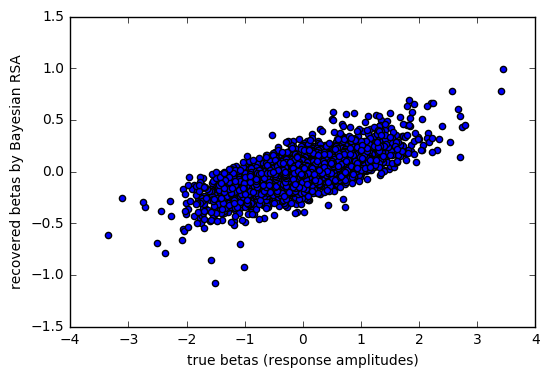

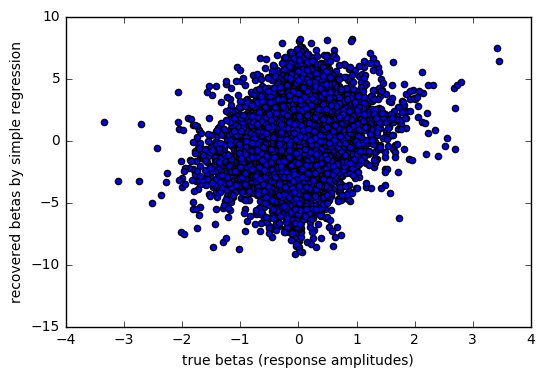

In [15]:
plt.scatter(betas_simulated / Y_std, brsa.beta_)
plt.xlabel('true betas (response amplitudes)')
plt.ylabel('recovered betas by Bayesian RSA')
ax = plt.gca()
plt.show()


plt.scatter(betas_simulated / Y_std, betas_point[1:, :])
plt.xlabel('true betas (response amplitudes)')
plt.ylabel('recovered betas by simple regression')
ax = plt.gca()
plt.show()

### The singular decomposition of noise, and the comparison between the first two principal component of noise and the patterns of the first two nuisance regressors, returned by the model. 
Because we z-scored data, there is not much activity related to the DC component nuisance regressor. The model can still fit without z-scoring the data. However, the estimation of nuisance regressors may be unstable.

Apparently one can imagine that the choice of the number of principal components used as nuisance regressors can influence the result. If you just choose 1 or 2, perhaps only the baseline and drift would be captured. But including too many nuisance regressors would slow the fitting speed and might have risk of overfitting. The users might consider starting in the range of 5-20. In future, we may consider using cross validation to determine the number of nuisance regressors, similar as in GLMdenoise (http://kendrickkay.net/GLMdenoise/)

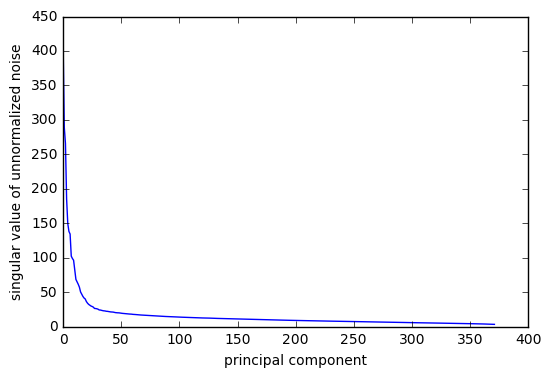

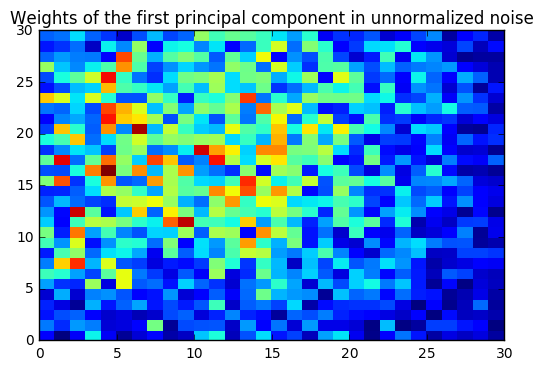

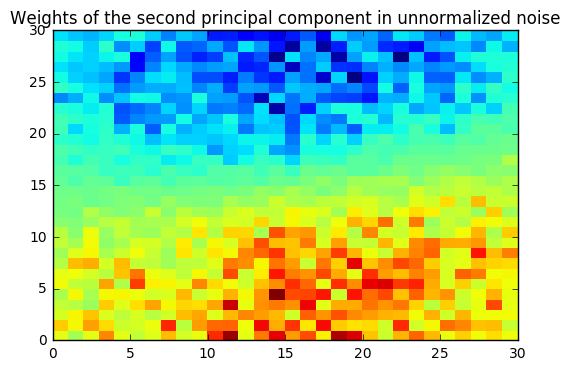

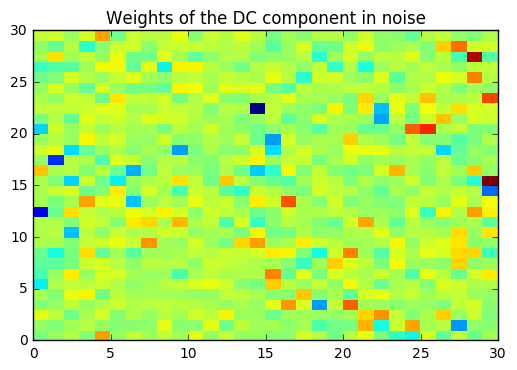

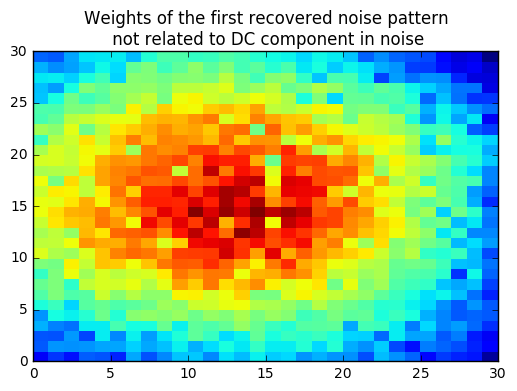

In [16]:
u, s, v = np.linalg.svd(noise)
plt.plot(s)
plt.xlabel('principal component')
plt.ylabel('singular value of unnormalized noise')
plt.show()

plt.pcolor(np.reshape(v[0,:], [ROI_edge, ROI_edge]))
plt.title('Weights of the first principal component in unnormalized noise')
plt.show()
plt.pcolor(np.reshape(v[1,:], [ROI_edge, ROI_edge]))
plt.title('Weights of the second principal component in unnormalized noise')
plt.show()


plt.pcolor(np.reshape(brsa.beta0_[0,:], [ROI_edge, ROI_edge]))
plt.title('Weights of the DC component in noise')
plt.show()

plt.pcolor(np.reshape(brsa.beta0_[1,:], [ROI_edge, ROI_edge]))
plt.title('Weights of the first recovered noise pattern\n not related to DC component in noise')
plt.show()

## "Decoding" from new data
### Now we generate a new data set, assuming signal is the same but noise is regenerated. We want to use the transform() function of brsa to estimate the "design matrix" in this new dataset.

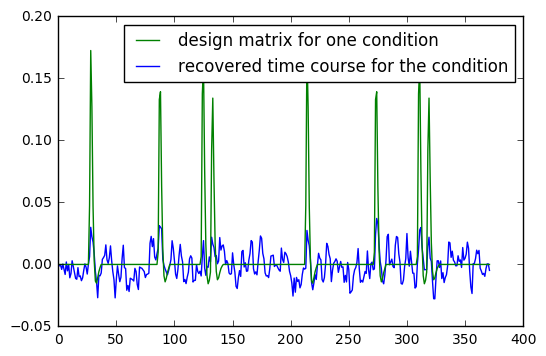

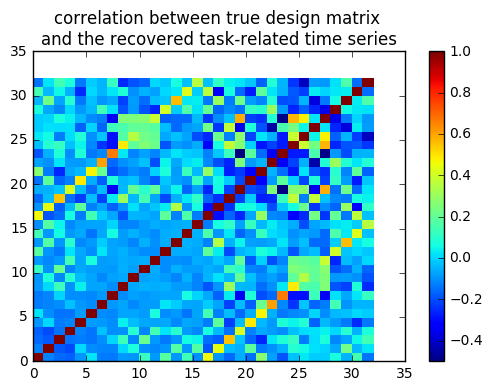

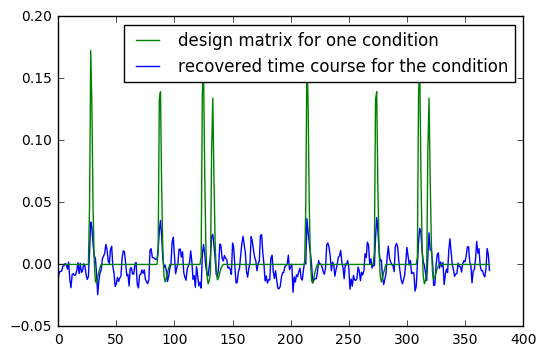

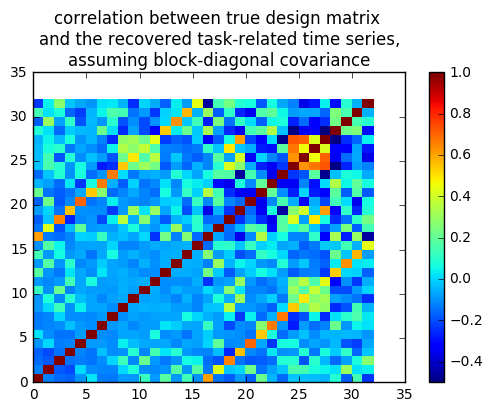

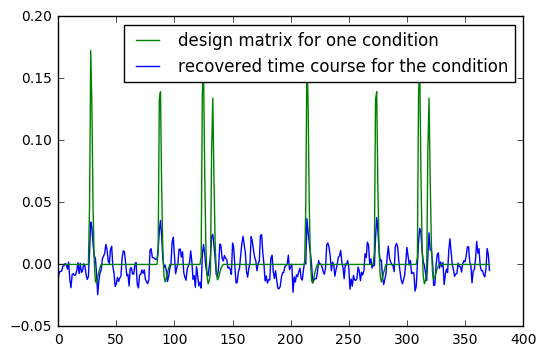

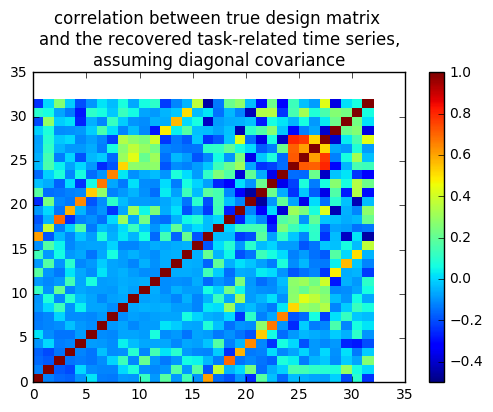

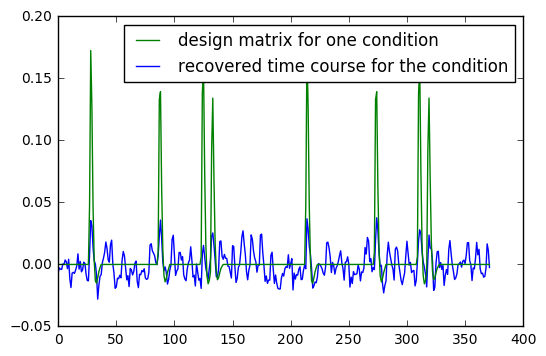

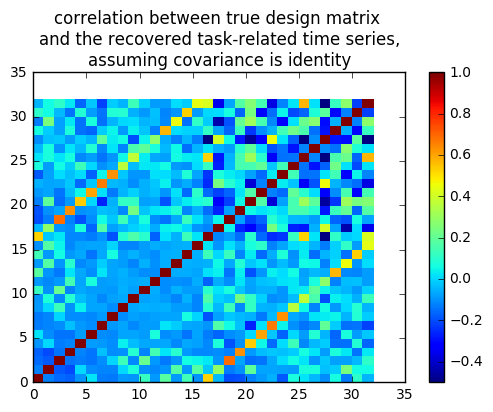

In [17]:
noise_new = np.zeros([n_T, n_V])
noise_new[0, :] = np.dot(L_noise, np.random.randn(n_V))\
    / np.sqrt(1 - rho1**2)
for i_t in range(1, n_T):
    noise_new[i_t, :] = noise_new[i_t - 1, :] * rho1 \
        + np.dot(L_noise,np.random.randn(n_V))
Y_new = signal + noise_new + inten

ts, ts0 = brsa.transform(scipy.stats.zscore(Y_new,axis=0),scan_onsets=scan_onsets)
# ts, ts0 = brsa.transform(Y_new,scan_onsets=scan_onsets)
recovered_plot, = plt.plot(ts[:, 8], 'b')
design_plot, = plt.plot(design.design_task[:, 8], 'g')
plt.legend([design_plot, recovered_plot],
           ['design matrix for one condition', 'recovered time course for the condition'])
plt.show()



plt.pcolor(np.corrcoef(design.design_task.T,ts.T),vmin=-0.5,vmax=1)
plt.title('correlation between true design matrix \nand the recovered task-related time series')
plt.colorbar()
plt.show()

ts, ts0 = brsa.transform(scipy.stats.zscore(Y_new,axis=0),scan_onsets=scan_onsets, prior_ts_cov='Block')
recovered_plot, = plt.plot(ts[:, 8], 'b')
design_plot, = plt.plot(design.design_task[:, 8], 'g')
plt.legend([design_plot, recovered_plot],
           ['design matrix for one condition', 'recovered time course for the condition'])
plt.show()
plt.pcolor(np.corrcoef(design.design_task.T,ts.T),vmin=-0.5,vmax=1)
plt.title('correlation between true design matrix \nand the recovered task-related time series,\nassuming block-diagonal covariance')
plt.colorbar()
plt.show()

recovered_plot, = plt.plot(ts[:, 8], 'b')
design_plot, = plt.plot(design.design_task[:, 8], 'g')
plt.legend([design_plot, recovered_plot],
           ['design matrix for one condition', 'recovered time course for the condition'])
plt.show()
ts, ts0 = brsa.transform(scipy.stats.zscore(Y_new,axis=0),scan_onsets=scan_onsets, prior_ts_cov='Diag')
plt.pcolor(np.corrcoef(design.design_task.T,ts.T),vmin=-0.5,vmax=1)
plt.title('correlation between true design matrix \nand the recovered task-related time series,\nassuming diagonal covariance')
plt.colorbar()
plt.show()

recovered_plot, = plt.plot(ts[:, 8], 'b')
design_plot, = plt.plot(design.design_task[:, 8], 'g')
plt.legend([design_plot, recovered_plot],
           ['design matrix for one condition', 'recovered time course for the condition'])
plt.show()
ts, ts0 = brsa.transform(scipy.stats.zscore(Y_new,axis=0),scan_onsets=scan_onsets, prior_ts_cov=1.0)
plt.pcolor(np.corrcoef(design.design_task.T,ts.T),vmin=-0.5,vmax=1)
plt.title('correlation between true design matrix \nand the recovered task-related time series,\nassuming covariance is identity')
plt.colorbar()
plt.show()


# We can also try the version which marginalize SNR and rho for each voxel (experimenting)

In [ ]:
Y_z = scipy.stats.zscore(Y,axis=0)
Y_std = np.std(Y,axis=0)
# Z-scoreing the data

brsa = GBRSA(nureg_method='PCA', n_nureg=20, auto_nuisance=True, logS_range=2,
            anneal_speed=20, prior_ts_cov='Full', n_iter=50)
# Initiate an instance, telling it
# that we want to impose Gaussian Process prior
# over both space and intensity.

z_score = True
if z_score:
    brsa.fit(X=Y_z, design=design.design_task,scan_onsets=scan_onsets)
else:
    brsa.fit(X=Y, design=design.design_task,scan_onsets=scan_onsets)

# The data to fit should be given to the argument X.
# Design matrix goes to design. And so on.


In [ ]:
plt.pcolor(np.reshape(brsa.nSNR_, (ROI_edge, ROI_edge)), cmap='Reds')
plt.colorbar()
plt.title('SNR map estimated by marginalized BRSA')
plt.show()
plt.pcolor(np.reshape(snr, (ROI_edge, ROI_edge)), cmap='Reds')
plt.colorbar()
plt.title('true SNR map')
plt.show()

plt.scatter(snr, brsa.nSNR_)
plt.xlabel('simulated pseudo-SNR')
plt.ylabel('estimated pseudo-SNR')
plt.show()
plt.scatter(np.log(snr), np.log(brsa.nSNR_))
plt.xlabel('simulated log(pseudo-SNR)')
plt.ylabel('estimated log(pseudo-SNR)')
plt.show()

plt.pcolor(brsa.U_)
plt.colorbar()
plt.title('covariance matrix estimated by marginalized BRSA')
plt.show()
plt.pcolor(ideal_cov)
plt.colorbar()
plt.title('true covariance matrix')
plt.show()
plt.scatter(betas_simulated, brsa.beta_)
plt.xlabel('simulated betas')
plt.ylabel('betas estimated by marginalized BRSA')
plt.show()
if not z_score:
    plt.scatter(noise_level, brsa.sigma_)
    plt.xlabel('simulated noise level')
    plt.ylabel('noise level estimated by marginalized BRSA')
    plt.show()
plt.scatter(rho1, brsa.rho_)
plt.xlabel('simulated Ar(1) coefficients')
plt.ylabel('AR(1) coefficients estimated by marginalized BRSA')
plt.show()

In [ ]:
noise_new = np.zeros([n_T, n_V])
noise_new[0, :] = np.dot(L_noise, np.random.randn(n_V))\
    / np.sqrt(1 - rho1**2)
for i_t in range(1, n_T):
    noise_new[i_t, :] = noise_new[i_t - 1, :] * rho1 \
        + np.dot(L_noise,np.random.randn(n_V))
Y_new = signal + noise_new + inten

ts, ts0 = brsa.transform(scipy.stats.zscore(Y_new,axis=0),scan_onsets=scan_onsets)
# ts, ts0 = brsa.transform(Y_new,scan_onsets=scan_onsets)
recovered_plot, = plt.plot(ts[:, 8], 'b')
design_plot, = plt.plot(design.design_task[:, 8], 'g')
plt.legend([design_plot, recovered_plot],
           ['design matrix for one condition', 'recovered time course for the condition'])
plt.show()



plt.pcolor(np.corrcoef(design.design_task.T,ts.T),vmin=-0.5,vmax=1)
plt.title('correlation between true design matrix \nand the recovered task-related time series')
plt.colorbar()
plt.show()

In [ ]:
import imp
import brainiak.reprsimil.brsa as brsa
imp.reload(brsa)
MBRSA = brsa.MBRSA()
MBRSA.fit(X=[Y_z], design=[design.design_task],scan_onsets=[scan_onsets])